In [7]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

In [8]:
# Hyperparameters
img_width, img_height = 224, 224
batch_size = 32
epochs = 20
initial_learning_rate = 0.001

# Data directories
train_data_dir = 'C:/Users/rithv/OneDrive/Desktop/skincancerCNN/skin_cancer_isic/Train' 
test_data_dir = 'C:/Users/rithv/OneDrive/Desktop/skincancerCNN/skin_cancer_isic/Test'    


In [9]:
# Data augmentation for training set
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

# Rescale images for testing set (no augmentation)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load the training data
train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_width, img_height),
                                                    batch_size=batch_size, class_mode='categorical')

# Load the testing data
test_generator = test_datagen.flow_from_directory(test_data_dir, target_size=(img_width, img_height),
                                                  batch_size=batch_size, class_mode='categorical')


Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


In [10]:
# Define the CNN model
model = Sequential()

# First dense block with Convolution, BatchNormalization, Activation, and MaxPooling layers
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(img_width, img_height, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second dense block with Convolution, BatchNormalization, Activation, and MaxPooling layers
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third dense block with Convolution, BatchNormalization, Activation, and MaxPooling layers
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Global Average Pooling to reduce spatial dimensions
model.add(tf.keras.layers.GlobalAveragePooling2D())

# Dense layer with dropout for classification
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))  # Output layer with 9 classes (diseases)

# Compile the model with learning rate scheduling and gradient clipping
initial_learning_rate = 0.001

def lr_schedule(epoch):
    lr = initial_learning_rate
    if epoch > 7:
        lr *= 0.1
    elif epoch > 50:
        lr *= 0.01
    return lr

reduce_lr = LearningRateScheduler(lr_schedule)

model.compile(optimizer=Adam(clipvalue=0.5), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# Train the model with learning rate scheduler and gradient clipping
history = model.fit(train_generator, steps_per_epoch=len(train_generator), epochs=epochs,
                    validation_data=test_generator, validation_steps=len(test_generator),
                    callbacks=[reduce_lr])


Epoch 1/20
70/70 [==============================] - 282s 4s/step - loss: 1.7402 - accuracy: 0.3765 - val_loss: 2.4368 - val_accuracy: 0.1356 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 272s 4s/step - loss: 1.5814 - accuracy: 0.4180 - val_loss: 2.5153 - val_accuracy: 0.1356 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 262s 4s/step - loss: 1.5482 - accuracy: 0.4337 - val_loss: 2.5635 - val_accuracy: 0.1356 - lr: 0.0010
Epoch 4/20
70/70 [==============================] - 244s 3s/step - loss: 1.5260 - accuracy: 0.4381 - val_loss: 2.4180 - val_accuracy: 0.1356 - lr: 0.0010
Epoch 5/20
70/70 [==============================] - 247s 4s/step - loss: 1.4609 - accuracy: 0.4743 - val_loss: 2.5326 - val_accuracy: 0.1780 - lr: 0.0010
Epoch 6/20
70/70 [==============================] - 243s 3s/step - loss: 1.4489 - accuracy: 0.4694 - val_loss: 2.2742 - val_accuracy: 0.1695 - lr: 0.0010
Epoch 7/20
70/70 [==============================] - 241s 3s/step - loss: 1.4

In [12]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')


4/4 [==============================] - 8s 2s/step - loss: 2.1737 - accuracy: 0.2712
Test loss: 2.1736631393432617, Test accuracy: 0.2711864411830902


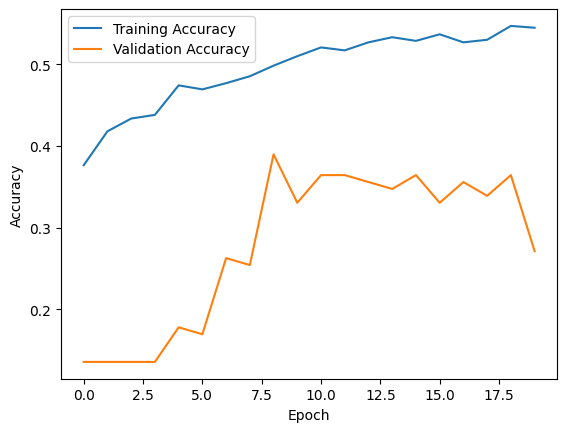

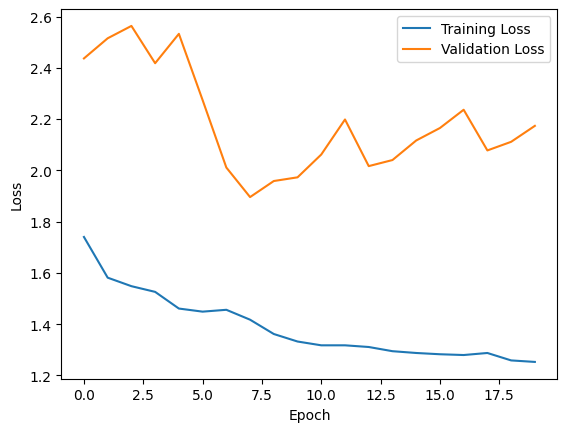

In [13]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


1/1 [==============================] - 0s 87ms/step


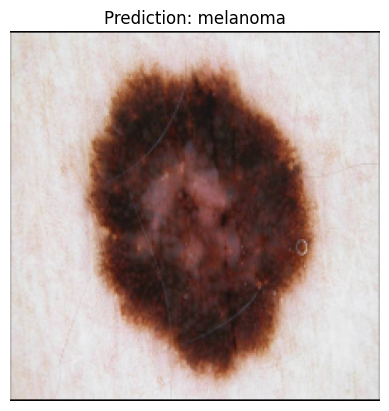

In [22]:
import matplotlib.pyplot as plt
import cv2


# Define a function to predict skin cancer type for a given image path
def predict_skin_cancer_type(image_path):
    # Load the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Preprocess the image for prediction
    img = cv2.resize(img, (img_width, img_height))
    img = np.expand_dims(img, axis=0)
    img = img / 255.0

    # Get the prediction
    prediction = model.predict(img)
    disease_classes = ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma',
                       'nevus', 'pigmented benign keratosis', 'seborrheic keratosis',
                       'squamous cell carcinoma', 'vascular lesion']
    predicted_class = disease_classes[np.argmax(prediction)]

    # Plot the image and prediction
    plt.imshow(img[0])
    plt.title(f'Prediction: {predicted_class}')
    plt.axis('off')
    plt.show()

# Example usage: Replace 'image_path_to_test' with the path of your desired image
image_path_to_test = 'C:/Users/rithv/OneDrive/Desktop/skincancerCNN/skin_cancer_isic/Test/melanoma\ISIC_0000029.jpg'


# actinic keratosis - C:\Users\rithv\OneDrive\Desktop\skincancerCNN\skin_cancer_isic\Test\actinic keratosis\ISIC_0024800.jpg
# basal cell carcinoma - C:\Users\rithv\OneDrive\Desktop\skincancerCNN\skin_cancer_isic\Test\basal cell carcinoma\ISIC_0024345.jpg
# dermatofibroma - C:\Users\rithv\OneDrive\Desktop\skincancerCNN\skin_cancer_isic\Test\dermatofibroma\ISIC_0024396.jpg
# melanoma - C:\Users\rithv\OneDrive\Desktop\skincancerCNN\skin_cancer_isic\Test\melanoma\ISIC_0000029.jpg
# nevus - C:\Users\rithv\OneDrive\Desktop\skincancerCNN\skin_cancer_isic\Test\nevus\ISIC_0000011.jpg
# pigmented benign keratosis - C:\Users\rithv\OneDrive\Desktop\skincancerCNN\skin_cancer_isic\Test\pigmented benign keratosis\ISIC_0024381.jpg
# -seborrheic keratosis - C:\Users\rithv\OneDrive\Desktop\skincancerCNN\skin_cancer_isic\Test\seborrheic keratosis\ISIC_0010808.jpg
# squamous cell carcinoma - C:\Users\rithv\OneDrive\Desktop\skincancerCNN\skin_cancer_isic\Test\squamous cell carcinoma\ISIC_0024418.jpg
# vascular lesion - C:\Users\rithv\OneDrive\Desktop\skincancerCNN\skin_cancer_isic\Test\vascular lesion\ISIC_0024375.jpg


predict_skin_cancer_type(image_path_to_test)
